In [1]:
from PIL import Image
import tqdm
import os
import time
import collections

import torch
import torchvision
assert torch.cuda.is_available()
from torchvision.transforms import ToTensor
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 40
VAL_SIZE = 0.2
IM_SIZE = (128, 128)
DEVICE = 'cuda:0'

----------------
## Создание Custom Dataset  и DataLoader
Объект класса ImageDataset подгружает файл с нужным изображением при вызове метода \__getitem__.

Работа происходит в цветовом пространстве HSV:
- hue - оттенок (image[0]),
- saturation - насыщенность (image[1]),
- value - значение яркости (image[2])

Яркость будет неизменным и опорным значением для модели, по которому будут рассчитываться два оставшихся параметра, влияющих на цвет.


In [2]:
def dataset_preparation(in_path, out_path, im_size):
    ''' перезаписывает файлы в другую папку + resize '''
    files_list = os.listdir(in_path)
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    for file_n in tqdm.tqdm(files_list):
        with Image.open(in_path+file_n) as file:
            file.resize(im_size).save(out_path+file_n)

class ImageDataset(torch.utils.data.Dataset):
    ''' 
    Формат файлов: png или jpg
    amount - временное решение по ограничению кол-ва обучающих данных
    '''
    
    def __init__(self, path, transforms, amount = None, to_hsv = True):
        self.transforms = transforms
        self.to_hsv = to_hsv
        self.path = path
        
        is_image_filter = lambda value:('png' in value) or ('jpg' in value) or ('JPEG' in value)
        self.f_names = list(filter(is_image_filter, os.listdir(path)))[:amount]
        self.len = len(self.f_names)
        
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        with Image.open(self.path + self.f_names[index]) as file:
            image = self.transforms(file.convert('HSV')) 
            return image[2].unsqueeze(0), image[:2]     # unsqueeze на случай реализации vgg16
                                                        # image shape - [hue, sat, val], return [newax, h, s]

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
dataset_preparation(in_path = 'imagenet_val_mini/',
                    out_path = 'im_dataset/',
                    im_size = IM_SIZE)
dataset = ImageDataset(path = 'im_dataset/', transforms = transforms)

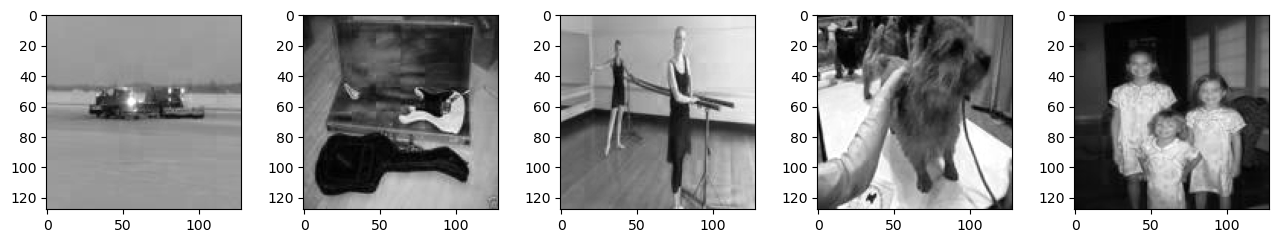

In [3]:
%matplotlib inline
_, ax = plt.subplots(1, 5, figsize = (13, 5))
plt.tight_layout()
for i in range(5):
    ax[i].imshow(dataset[i][0].permute(1, 2, 0), cmap = 'gray')

In [4]:
def val_split(dataset, val_size):
    ''' val_size задается в диапазоне 0..1 '''
    val_length = int(np.round(len(dataset) * val_size))
    val_idx = range(val_length)
    train_idx = range(val_length, len(dataset))
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    return train_sampler, val_sampler

train_sampler, val_sampler = val_split(dataset, val_size = VAL_SIZE)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler, drop_last = True)
val_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = val_sampler, drop_last = True)

---------------------------------------
## Архитектура модели


In [5]:
class Discriminator(torch.nn.Module):
    def __init__(self, optim, batch_size):
        super(Discriminator, self).__init__()
        
        self.l1_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 2, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 2, padding = 1),
            torch.nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 2, padding = 1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 2, padding = 1),
            torch.nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 2, padding = 1)
        )
        flatten_size = int(8 *((256 / 2 / 2 / 2 / 2 / 2)**2))
        
        self.l2_fc = torch.nn.Sequential(
            torch.nn.Linear(size, 32),
            torch.nn.Dropout(0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid()
        )
        
        self.loss_fn = torch.nn.BCELoss()
        self.optim = optim(self.parameters(), lr = .0001)
    
    def calc_loss(self, outputs, targets):
        return self.loss_fn(outputs, targets)
    
    def forward(self, x):
        x = self.l1_conv(x)
#         print('disc conv: ', x.shape)
        x = x.view(self.batch_size, -1)
        x = self.l2_fc(x)
        return x


class StylerNet(torch.nn.Module):
    ''' '''
    
    def __init__(self, optim):
        super(StylerNet, self).__init__()

        self.l1_encoder = torch.nn.Sequential(
            
            collections.OrderedDict({
                'conv1': torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1, stride = 2),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(64)
                ),
                'conv2': torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1, stride = 2),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(128)
                ),
                'conv3': torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1, stride = 2),
                    torch.nn.LeakyReLU(), 
                    torch.nn.BatchNorm2d(256),
                ),
                'conv4': torch.nn.Sequential(            
                    torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1, stride = 2),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(512)
                )
            })
        )
        self.l2_decoder = torch.nn.Sequential(
            
            collections.OrderedDict({
                'convTranspose1': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(256)
                ),
                'convTranspose2': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(128),
                ),
                'convTranspose3': torch.nn.Sequential(            
                    torch.nn.ConvTranspose2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(64),
                ),
                'convTranspose4': torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(32),
                ),
                'convOut': torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels = 32, out_channels = 2, kernel_size = 3, padding = 1),
                    torch.nn.BatchNorm2d(2),
                    torch.nn.Sigmoid()
                )
            })    
        )
        self.loss_fn = torch.nn.BCELoss()
        self.optim = optim(self.parameters(), lr = .001, weight_decay=0.01)
        
    def forward(self, x):
        x = self.l1_encoder.conv1(x)         # (, 64, 64, 64)
        x = self.l1_encoder.conv2(x)         # (, 128, 32, 32)
        x = self.l1_encoder.conv3(x)         # (, 256, 16, 16)
        x = self.l1_encoder.conv4(x)         # (, 512, 8, 8)
        
        x = self.l2_decoder.convTranspose1(x) # (, 256, 16, 16)
        x = self.l2_decoder.convTranspose2(x) # (, 128, 32, 32)
        x = self.l2_decoder.convTranspose3(x) # (, 64, 64, 64)
        x = self.l2_decoder.convTranspose4(x) # (, 32, 128, 128)
        
        x = self.l2_decoder.convOut(x)
        return x
    
    def calc_loss(self, outputs, targets):
        return self.loss_fn(outputs, targets)
            
    def predict(self, inputs):
        topillow = torchvision.transforms.ToPILImage('HSV')
        image = topillow(torch.hstack([self(inputs.to(DEVICE)), inputs.to(DEVICE)])[0])
        return image
    def checkpoint(self, direction, epoch):
        torch.save(self.state_dict, direction + f'model_{epoch}')
    def load_checkpoint(self, direction, epoch):
        self.load_state_dict(torch.load(direction + f'model_{epoch}')())

--------------
## Обучение

In [6]:
def train_model3(model, discriminator, train_loader, epochs = 1, device = DEVICE):
    model.to(device)
    model.train()
    discriminator.to(device)
    discriminator.train()
    
    # для val_loss
    calc_loss = torch.nn.MSELoss()
    topillow = torchvision.transforms.ToPILImage('HSV')
    image = next(iter(train_loader))     # image shape   [[s, h], v]
    
    point = np.ceil(len(train_loader) / 10)
    losses = [np.array([]), np.array([])]
    
    for epoch in range(epochs):
        model.to(device)
        start_time = time.time()
        print(f'Epoch {epoch}/{epochs}: <', end = '')
        
        for i, (inputs, targets) in enumerate(train_loader):
            
            discriminator.optim.zero_grad()
            model_outs = model(inputs.to(device)).detach()
            disc_fake_outs = discriminator(model_outs)
            disc_real_outs = discriminator(targets.to(device))
            disc_fake_loss = discriminator.calc_loss(disc_fake_outs, torch.zeros_like(disc_fake_outs))         
            disc_real_loss = discriminator.calc_loss(disc_real_outs, torch.ones_like(disc_real_outs))
            disc_loss = disc_real_loss + disc_fake_loss
            disc_loss.backward()
            if disc_loss > 0.02:  
                discriminator.optim.step()

            model.optim.zero_grad()
            model_outs = model(inputs.to(device))
            disc_fake_outs = discriminator(model_outs)
            model_loss = model.calc_loss(disc_fake_outs, torch.ones_like(disc_fake_outs))
            model_loss.backward()
            model.optim.step()
            
            
            if not i % point:
                print('=', end = '')
                
        print(f'> ------- disc loss = {disc_loss}, model loss = {model_loss}, time = {np.round(time.time() - start_time)}s')
        
        losses[0] = np.append(losses[0], disc_loss.detach().to('cpu').numpy())
        losses[1] = np.append(losses[1], model_loss.detach().to('cpu').numpy())
        
        
        if not epoch % 5:
            model.checkpoint('checkpoints/', epoch)
            
            # расчет validation loss    
            with torch.no_grad():                  
                val_loss = 0
                for i, (inputs, targets) in enumerate(val_loader):
                    outputs = model(inputs.to(device))
                    val_loss += calc_loss(outputs, targets.to(device))
                val_loss = val_loss / i
                print(f'\nValidation loss = {val_loss}')
                
                # визуальный вывод
                fake_im = model.predict(image[0])
                real_im = topillow(torch.hstack((image[1], image[0]))[0])
                _, ax = plt.subplots(1, 3, figsize = (10, 2))
                plt.tight_layout()
                ax[0].set_title('fake image')
                ax[0].imshow(fake_im)
                ax[1].set_title('real image')
                ax[1].imshow(real_im)
                ax[2].set_title('losses')
                ax[2].plot(losses[0], label = 'discriminator loss')
                ax[2].plot(losses[1], label = 'model loss')
                ax[2].legend()
                plt.show()
                

    return losses

In [7]:
model = StylerNet(optim = torch.optim.Adam)
discriminator = Discriminator(optim = torch.optim.Adam, batch_size = BATCH_SIZE)

model_params_amount = (sum(p.numel() for p in model.parameters()))
disc_params_amount = (sum(p.numel() for p in discriminator.parameters()))
params_total_amount = model_params_amount + disc_params_amount
print(f'Количество параметров модели: {model_params_amount}')
print(f'Количество параметров дискриминатора: {disc_params_amount}')
print(f'Количество параметров общее: {params_total_amount}')

Количество параметров модели: 9389286
Количество параметров дискриминатора: 78841
Количество параметров общее: 9468127


In [9]:
# prediction = model(next(iter(train_loader))[0])
# prediction.shape

In [10]:
# optim = torch.optim.Adam
# model_copy = StylerNet(optim)
# model_copy.load_state_dict(model.state_dict())

In [11]:
# disc_state_dict = discriminator.state_dict()
# discriminator_copy = Discriminator(optim)
# discriminator_copy.load_state_dict(disc_state_dict)

Epoch 0/1000: <==========> ------- disc loss = 0.26417258381843567, model loss = 3.0210423469543457, time = 37.0s

Validation loss = 3.007899522781372


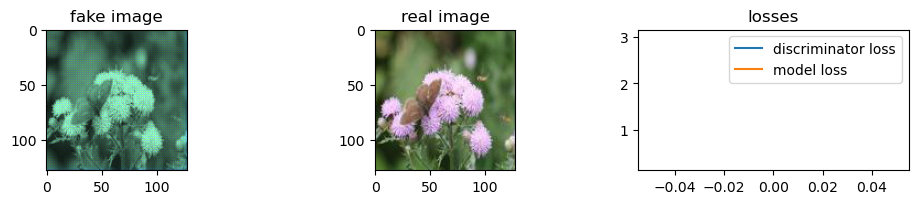

Epoch 1/1000: <==========> ------- disc loss = 0.12970763444900513, model loss = 3.417158603668213, time = 35.0s
Epoch 2/1000: <==========> ------- disc loss = 0.1459004282951355, model loss = 3.435143232345581, time = 35.0s
Epoch 3/1000: <==========> ------- disc loss = 0.3803864121437073, model loss = 2.0214405059814453, time = 35.0s
Epoch 4/1000: <==========> ------- disc loss = 0.02758498676121235, model loss = 4.150271892547607, time = 35.0s
Epoch 5/1000: <==========> ------- disc loss = 0.037696611136198044, model loss = 3.7371826171875, time = 35.0s

Validation loss = 3.1413793563842773


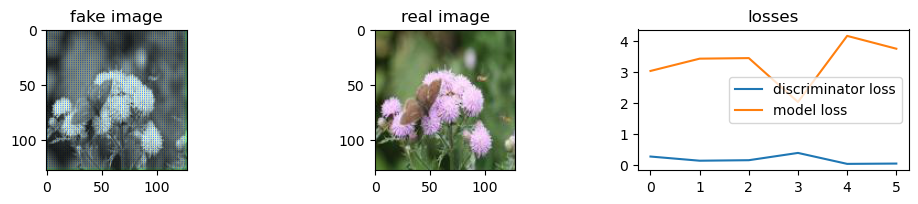

Epoch 6/1000: <==========> ------- disc loss = 0.02981734275817871, model loss = 4.027156829833984, time = 35.0s
Epoch 7/1000: <==========> ------- disc loss = 1.6098638772964478, model loss = 3.935194730758667, time = 35.0s
Epoch 8/1000: <==========> ------- disc loss = 0.074003666639328, model loss = 4.057034969329834, time = 35.0s
Epoch 9/1000: <==========> ------- disc loss = 0.10114504396915436, model loss = 4.507767200469971, time = 35.0s
Epoch 10/1000: <==========> ------- disc loss = 0.03208289295434952, model loss = 4.66074800491333, time = 35.0s

Validation loss = 3.4630494117736816


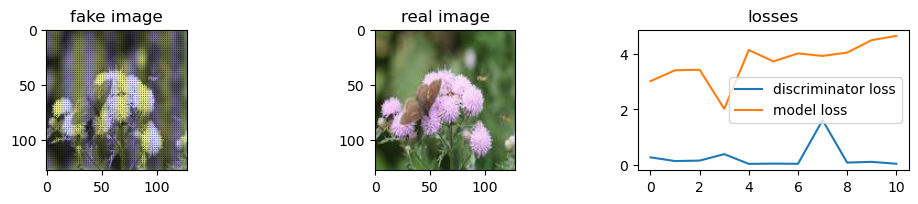

Epoch 11/1000: <==========> ------- disc loss = 1.660275936126709, model loss = 0.46446141600608826, time = 36.0s
Epoch 12/1000: <==========> ------- disc loss = 1.0639053583145142, model loss = 1.8801071643829346, time = 36.0s
Epoch 13/1000: <==========> ------- disc loss = 0.7954431772232056, model loss = 0.9378044009208679, time = 36.0s
Epoch 14/1000: <==========> ------- disc loss = 0.8329818248748779, model loss = 1.3707393407821655, time = 36.0s
Epoch 15/1000: <==========> ------- disc loss = 0.627109706401825, model loss = 1.1470128297805786, time = 36.0s

Validation loss = 3.4875941276550293


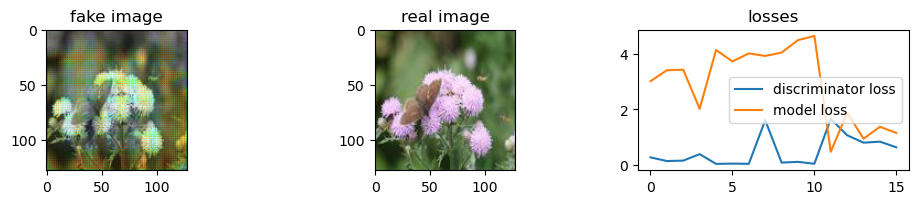

Epoch 16/1000: <==========> ------- disc loss = 1.2695715427398682, model loss = 0.827143669128418, time = 36.0s
Epoch 17/1000: <==========> ------- disc loss = 1.3178684711456299, model loss = 0.8477096557617188, time = 37.0s
Epoch 18/1000: <==========> ------- disc loss = 1.1679409742355347, model loss = 0.802157998085022, time = 37.0s
Epoch 19/1000: <==========> ------- disc loss = 1.0463078022003174, model loss = 0.7575618624687195, time = 37.0s
Epoch 20/1000: <==========> ------- disc loss = 1.1314071416854858, model loss = 0.7274457812309265, time = 36.0s

Validation loss = 3.7098803520202637


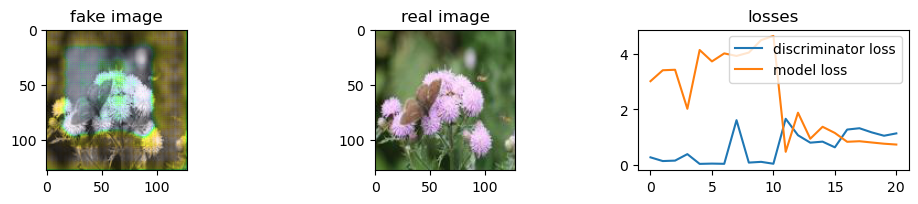

Epoch 21/1000: <==========> ------- disc loss = 1.1011297702789307, model loss = 0.7522860169410706, time = 36.0s
Epoch 22/1000: <==========> ------- disc loss = 1.0041389465332031, model loss = 0.748342752456665, time = 36.0s
Epoch 23/1000: <==========> ------- disc loss = 1.1345802545547485, model loss = 0.7531391382217407, time = 36.0s
Epoch 24/1000: <==========> ------- disc loss = 1.038661241531372, model loss = 0.746132493019104, time = 36.0s
Epoch 25/1000: <==========> ------- disc loss = 1.0904686450958252, model loss = 0.7497484683990479, time = 36.0s

Validation loss = 3.6596953868865967


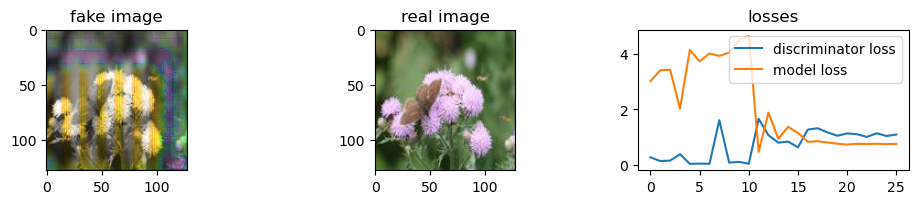

Epoch 26/1000: <==========> ------- disc loss = 1.0899884700775146, model loss = 0.7677296996116638, time = 36.0s
Epoch 27/1000: <==========> ------- disc loss = 1.1103520393371582, model loss = 0.7806269526481628, time = 36.0s
Epoch 28/1000: <==========> ------- disc loss = 0.9672242403030396, model loss = 0.7666935324668884, time = 36.0s
Epoch 29/1000: <==========> ------- disc loss = 1.0494441986083984, model loss = 0.7570695281028748, time = 36.0s
Epoch 30/1000: <==========> ------- disc loss = 1.131752610206604, model loss = 0.7543283700942993, time = 36.0s

Validation loss = 3.752687454223633


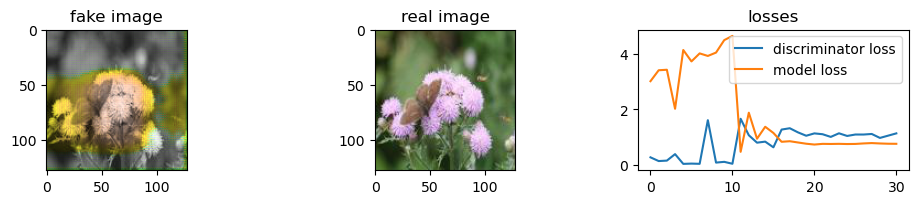

Epoch 31/1000: <==========> ------- disc loss = 1.1178562641143799, model loss = 0.749098002910614, time = 36.0s
Epoch 32/1000: <==========> ------- disc loss = 1.3013584613800049, model loss = 0.74434894323349, time = 36.0s
Epoch 33/1000: <==========> ------- disc loss = 1.2810821533203125, model loss = 0.7788836359977722, time = 36.0s
Epoch 34/1000: <==========> ------- disc loss = 1.1819429397583008, model loss = 0.7949206233024597, time = 36.0s
Epoch 35/1000: <==========> ------- disc loss = 0.9707725048065186, model loss = 0.7702215313911438, time = 36.0s

Validation loss = 3.64646577835083


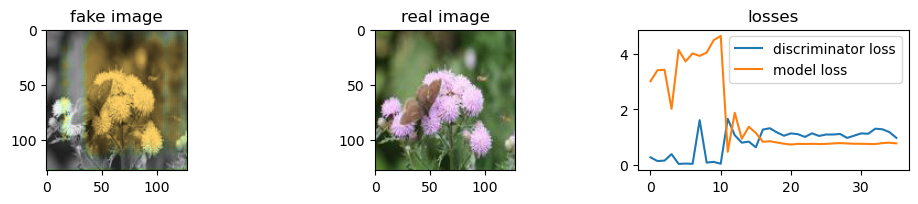

Epoch 36/1000: <==========> ------- disc loss = 1.2526724338531494, model loss = 0.7955537438392639, time = 36.0s
Epoch 37/1000: <==========> ------- disc loss = 1.1285417079925537, model loss = 0.7921854257583618, time = 36.0s
Epoch 38/1000: <==========> ------- disc loss = 0.978675127029419, model loss = 0.7737653851509094, time = 36.0s
Epoch 39/1000: <==========> ------- disc loss = 1.2028388977050781, model loss = 0.8167223930358887, time = 36.0s
Epoch 40/1000: <==========> ------- disc loss = 1.0739001035690308, model loss = 0.7754966616630554, time = 36.0s

Validation loss = 3.5323503017425537


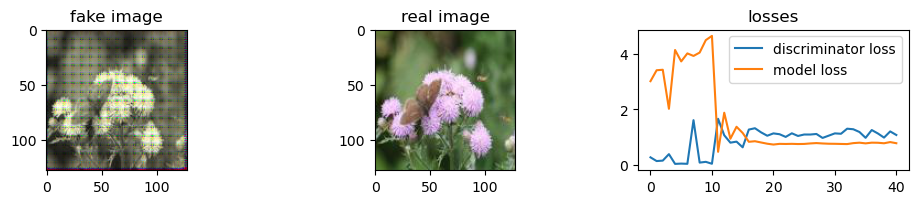

Epoch 41/1000: <==========> ------- disc loss = 1.1291234493255615, model loss = 0.7973182797431946, time = 36.0s
Epoch 42/1000: <==========> ------- disc loss = 0.9559016227722168, model loss = 0.7899399995803833, time = 36.0s
Epoch 43/1000: <==========> ------- disc loss = 1.2678167819976807, model loss = 0.7917493581771851, time = 36.0s
Epoch 44/1000: <==========> ------- disc loss = 1.1685268878936768, model loss = 0.7842535376548767, time = 36.0s
Epoch 45/1000: <==========> ------- disc loss = 0.9767990708351135, model loss = 0.7955329418182373, time = 36.0s

Validation loss = 3.5736615657806396


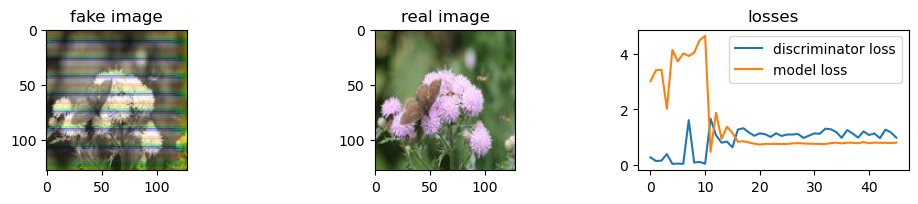

Epoch 46/1000: <==========> ------- disc loss = 1.0255086421966553, model loss = 0.7850450873374939, time = 36.0s
Epoch 47/1000: <==========> ------- disc loss = 1.050614833831787, model loss = 0.7962933778762817, time = 36.0s
Epoch 48/1000: <==========> ------- disc loss = 0.9399734735488892, model loss = 0.8070176243782043, time = 36.0s
Epoch 49/1000: <==========> ------- disc loss = 1.3342424631118774, model loss = 0.7620554566383362, time = 36.0s
Epoch 50/1000: <==========> ------- disc loss = 1.260532259941101, model loss = 0.8077947497367859, time = 36.0s

Validation loss = 3.3505871295928955


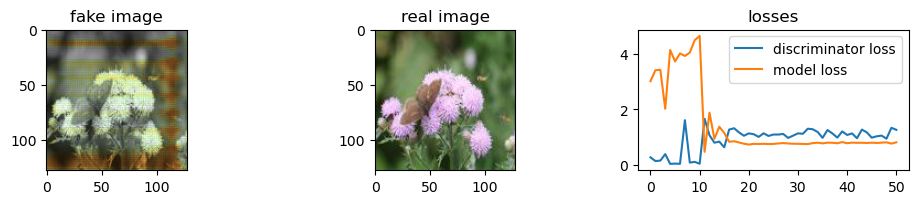

Epoch 51/1000: <==========> ------- disc loss = 1.0480270385742188, model loss = 0.8135951161384583, time = 36.0s
Epoch 52/1000: <=

KeyboardInterrupt: 

In [8]:
losses = train_model3(model, discriminator, train_loader, epochs = 1000, device = DEVICE)